In [1]:
import os
from pathlib import Path
import glob

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import mean_squared_error
from math import sqrt

from sewar.full_ref import uqi, psnr, rmse, ssim

import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from tensorflow.keras.utils import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)

In [2]:
input_dir  = Path('C:/Users/ozair/Documents/GlobalCertWeek4/')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

In [3]:
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))

print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


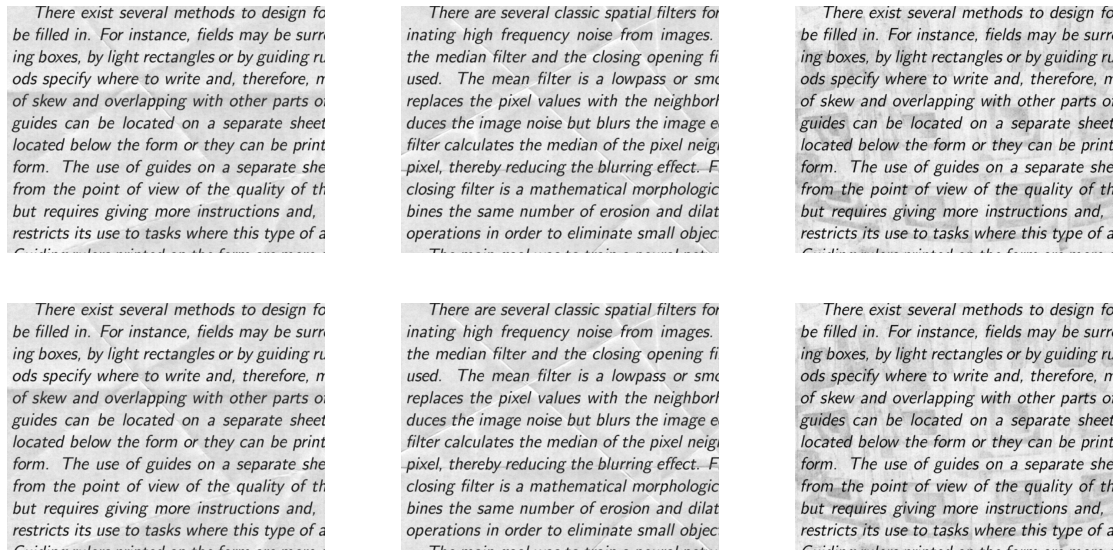

In [4]:
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(train/img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()    

In [5]:
def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    # Encoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    # Decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    # Model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [6]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 420, 540, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 420, 540, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 210, 270, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 210, 270, 64)      18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 105, 135, 64)      0         
                                                                 
 Conv3 (Conv2D)              (None, 105, 135, 64)      36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 210, 270, 64)      0     

In [7]:
X = []
Y = []

for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)


C:\Users\ozair\anaconda3\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [9]:
autoencoder.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/10
17/17 [==============================] - 36s 2s/step - loss: 0.4150 - val_loss: 0.3517
Epoch 2/10
17/17 [==============================] - 32s 2s/step - loss: 0.3222 - val_loss: 0.2894
Epoch 3/10
17/17 [==============================] - 34s 2s/step - loss: 0.2556 - val_loss: 0.2464
Epoch 4/10
17/17 [==============================] - 33s 2s/step - loss: 0.2265 - val_loss: 0.2223
Epoch 5/10
17/17 [==============================] - 33s 2s/step - loss: 0.2042 - val_loss: 0.2116
Epoch 6/10
17/17 [==============================] - 33s 2s/step - loss: 0.1898 - val_loss: 0.1928
Epoch 7/10
17/17 [==============================] - 34s 2s/step - loss: 0.1786 - val_loss: 0.1843
Epoch 8/10
17/17 [==============================] - 34s 2s/step - loss: 0.1709 - val_loss: 0.1853
Epoch 9/10
17/17 [==============================] - 35s 2s/step - loss: 0.1657 - val_loss: 0.1744
Epoch 10/10
17/17 [==============================] - 33s 2s/step - loss: 0.1592 - val_loss: 0.1667


1/1 [==============================] - 0s 146ms/step


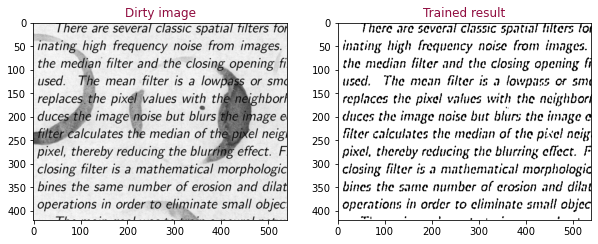

In [10]:
sample_test = load_img(train/ train_images[-1], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')

ax[0].set_title('Dirty image', color='#900c3f')
ax[1].set_title('Trained result', color='#900c3f')

plt.show()

1/1 [==============================] - 0s 69ms/step


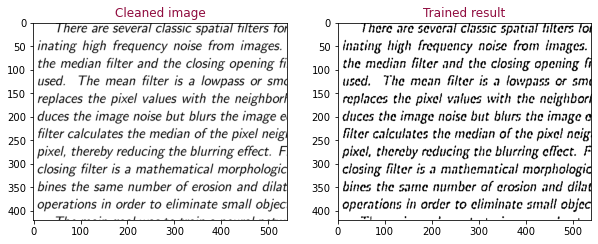

In [11]:
sample_test = load_img(train_cleaned/ train_images[-1], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')

ax[0].set_title('Cleaned image', color='#900c3f')
ax[1].set_title('Trained result', color='#900c3f')

plt.show()

In [12]:
print(type(np.squeeze(sample_test)))

<class 'numpy.ndarray'>


In [13]:
sample = np.squeeze(sample_test)
print("Shape:", sample.shape)
print(type(sample))

Shape: (420, 540)
<class 'numpy.ndarray'>


In [14]:
print(predicted_label.shape)
print(type(predicted_label))

(420, 540)
<class 'numpy.ndarray'>


In [15]:
print("RMSE:", rmse(sample, predicted_label))

RMSE: 234.27997938093554


In [16]:
print("UQI:", uqi(sample, predicted_label))

UQI: 5.8228805195325866e-05
